In [1]:
from __future__ import print_function, division
import geopandas as gpd
import numpy as np
import pandas as pd
import os
import sys
import json
import pylab as pl
import pysal as ps
from pandas import DataFrame
import matplotlib.pylab as plt
try:
    import ipywidgets as widgets
    hasWidgets = True
except ImportError:
    hasWidgets = False

from geopandas import GeoDataFrame

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
%pylab inline

puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")

puidata = os.getenv("PUIDATA")

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
!curl https://data.ny.gov/api/views/vpry-a23m/rows.csv?accessType=DOWNLOAD > liquorlicenses.csv
!mv liquorlicenses.csv $PUIDATA
licenses = pd.read_csv("%s/liquorlicenses.csv"%os.getenv("PUIDATA"))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  247k    0  247k    0     0   837k      0 --:--:-- --:--:-- --:--:--  837k


In [3]:
licenses.head()

,License Serial Number,License Type Name,License Class Code,License Type Code,Agency Zone Office Name,Agency Zone Office Number,County Name (Licensee),Premises Name,Doing Business As (DBA),Actual Address of Premises (Address1),...,City,State,Zip,License Certificate Number,License Original Issue Date,License Effective Date,License Expiration Date,Latitude,Longitude,Location
0,1010943,BREWER,101,D,New York City,1,KINGS,"BROOKLYN BREWERY CORP,THE",THE BROOKLYN BREWERY,79 N 11TH STREET,...,BROOKLYN,NY,11249,901056,NaN,07/01/2018,06/30/2019,40.721740,-73.957975,"(40.721740112, -73.9579749694)"
1,1045583,WINERY,301,DW,New York City,1,SUFFOLK,PINDAR VINEYARDS LLC,NaN,37645 STATE ROUTE 25,...,PECONIC,NY,11958,877797,NaN,04/01/2016,03/31/2019,41.032189,-72.465617,"(41.0321892138, -72.4656170785)"
2,1045790,FARM WINERY,302,FW,New York City,1,SUFFOLK,LOUGHLIN VINEYARDS INC,LOUGHLIN VINEYARDS,SOUTH MAIN ST,...,SAYVILLE,NY,11782,886617,12/21/1998,10/26/2016,12/31/2018,NaN,NaN,NaN
3,1045792,FARM WINERY,302,FW,New York City,1,SUFFOLK,PAUMANOK VINEYARDS LTD,NaN,1074 MAIN RD,...,AQUEBOGUE,NY,11931,881273,09/25/1990,09/01/2016,08/31/2019,0.000000,0.000000,"(0.0, 0.0)"
4,1045793,FARM WINERY,302,FW,New York City,1,SUFFOLK,CHANNING DAUGHTERS WINERY LLC,CHANNING DAUGHTERS,1927 SCUTTLEHOLE RD,...,BRIDGEHAMPTON,NY,11932,884604,12/08/1997,12/01/2016,11/30/2019,40.959540,-72.309901,"(40.9595397603, -72.3099013441)"


In [4]:
to_keep_licenses = ['License Type Name','License Original Issue Date']
to_cut_licenses = []
for i in range(len(licenses.columns)):
    if licenses.columns[i] in to_keep_licenses:
        pass
    else:
        to_cut_licenses.append(licenses.columns[i])
licenses.drop(to_cut_licenses, axis=1, inplace=True)

In [5]:
licenses.head()

,License Type Name,License Original Issue Date
0,BREWER,NaN
1,WINERY,NaN
2,FARM WINERY,12/21/1998
3,FARM WINERY,09/25/1990
4,FARM WINERY,12/08/1997


In [6]:
licensesgroup = licenses.groupby('License Type Name').count().reset_index()
licensesgroup

,License Type Name,License Original Issue Date
0,BREWER,10
1,"DISTILLER ""A-1""",60
2,"DISTILLER ""B""",3
3,"DISTILLER ""B-1""",16
4,"DISTILLER ""C""",3
5,FARM BREWER,217
6,"FARM DISTILLER ""D""",135
7,FARM WINERY,328
8,MICRO BREWER,210
9,RESTAURANT BREWER,44


In [7]:
dictionary = {'BREWER':'Brewery', 'DISTILLER "A-1"':'Distillery', 'DISTILLER "B"':'Distillery', 'DISTILLER "B-1"':'Distillery',
             'DISTILLER "C"':'Distillery', 'FARM DISTILLER "D"':'Distillery', 'FARM BREWER':'Brewery','MICRO BREWER':'Brewery',
             'RESTAURANT BREWER':'Brewery', 'WINERY':'Winery', 'WINERY / FARM WINERY RETAIL':'Winery', 'FARM WINERY':'Winery'}

licensesgroup['License Type Name'] = licensesgroup['License Type Name'].map(dictionary)
licensesgroup

,License Type Name,License Original Issue Date
0,Brewery,10
1,Distillery,60
2,Distillery,3
3,Distillery,16
4,Distillery,3
5,Brewery,217
6,Distillery,135
7,Winery,328
8,Brewery,210
9,Brewery,44


In [8]:
licenses['License Type Name'] = licenses['License Type Name'].map(dictionary)
licensesgroup2 = licenses.groupby('License Type Name').count().reset_index()
licensesgroup2

,License Type Name,License Original Issue Date
0,Brewery,481
1,Distillery,217
2,Winery,425


In [9]:
licenses.head(10)

,License Type Name,License Original Issue Date
0,Brewery,NaN
1,Winery,NaN
2,Winery,12/21/1998
3,Winery,09/25/1990
4,Winery,12/08/1997
5,Winery,12/23/1999
6,Winery,NaN
7,Winery,10/11/1988
8,Winery,11/08/1990
9,Winery,NaN


In [10]:
licenses.isnull().sum()

License Type Name               0
License Original Issue Date    53
dtype: int64

In [11]:
licenses = licenses.dropna()

In [12]:
licenses['License Original Issue Date'].dtype

dtype('O')

In [13]:
licenses['date'] = pd.to_datetime(licenses['License Original Issue Date'])

In [14]:
licenses['year'] = licenses['date'].dt.year
#source: https://stackoverflow.com/questions/30405413/python-pandas-extract-year-from-datetime-dfyear-dfdate-year-is-not/33757291

In [15]:
licenses.head()

,License Type Name,License Original Issue Date,date,year
2,Winery,12/21/1998,1998-12-21,1998
3,Winery,09/25/1990,1990-09-25,1990
4,Winery,12/08/1997,1997-12-08,1997
5,Winery,12/23/1999,1999-12-23,1999
7,Winery,10/11/1988,1988-10-11,1988


In [16]:
licenses_final = licenses.drop(['License Original Issue Date', 'date'], axis=1)
licenses_final.head()

,License Type Name,year
2,Winery,1998
3,Winery,1990
4,Winery,1997
5,Winery,1999
7,Winery,1988


In [17]:
licenses_final['Count'] =1

In [18]:
licenses_final_group = licenses_final.groupby(['License Type Name', 'year'], as_index=False)['Count'].sum()
#df_turnstile2 = df_turnstile1.groupby(['STATION','DATE'], as_index= False)['ENTRIES'].count()

#licenses_final_group = pd.pivot_table(licenses_final,index=["year"],values=["License Type Name"],aggfunc=np.sum)
licenses_final_group.head()

,License Type Name,year,Count
0,Brewery,1983,1
1,Brewery,1987,1
2,Brewery,1989,1
3,Brewery,1995,1
4,Brewery,1996,1


In [19]:
lfg = pd.pivot_table(licenses_final_group, index= 'year', columns='License Type Name', values="Count").reset_index()

In [20]:
lfg.head()

License Type Name,year,Brewery,Distillery,Winery
0,1970,NaN,NaN,1.0
1,1974,NaN,NaN,1.0
2,1977,NaN,NaN,1.0
3,1981,NaN,NaN,3.0
4,1982,NaN,NaN,1.0


In [21]:
lfg['Brewery'] = lfg['Brewery'].fillna(0)

In [22]:
lfg['Distillery'] = lfg['Distillery'].fillna(0)
lfg['Winery'] = lfg['Winery'].fillna(0)
lfg

License Type Name,year,Brewery,Distillery,Winery
0,1970,0.0,0.0,1.0
1,1974,0.0,0.0,1.0
2,1977,0.0,0.0,1.0
3,1981,0.0,0.0,3.0
4,1982,0.0,0.0,1.0
5,1983,1.0,0.0,0.0
6,1987,1.0,0.0,1.0
7,1988,0.0,0.0,5.0
8,1989,1.0,0.0,2.0
9,1990,0.0,0.0,3.0


In [34]:
lfg['Brewery_cumsum'] = lfg['Brewery'].cumsum()
lfg['Distillery_cumsum'] = lfg['Distillery'].cumsum()
lfg['Winery_cumsum'] = lfg['Winery'].cumsum()
lfg = lfg.set_index('year')
lfg

License Type Name,Brewery,Distillery,Winery,Brewery_cumsum,Distillery_cumsum,Winery_cumsum
year,,,,,,
1970,0.0,0.0,1.0,0.0,0.0,1.0
1974,0.0,0.0,1.0,0.0,0.0,2.0
1977,0.0,0.0,1.0,0.0,0.0,3.0
1981,0.0,0.0,3.0,0.0,0.0,6.0
1982,0.0,0.0,1.0,0.0,0.0,7.0
1983,1.0,0.0,0.0,1.0,0.0,7.0
1987,1.0,0.0,1.0,2.0,0.0,8.0
1988,0.0,0.0,5.0,2.0,0.0,13.0
1989,1.0,0.0,2.0,3.0,0.0,15.0


In [36]:
lfg.columns

Index(['Brewery', 'Distillery', 'Winery', 'Brewery_cumsum',
       'Distillery_cumsum', 'Winery_cumsum'],
      dtype='object', name='License Type Name')

In [64]:
import matplotlib.pyplot as plt  


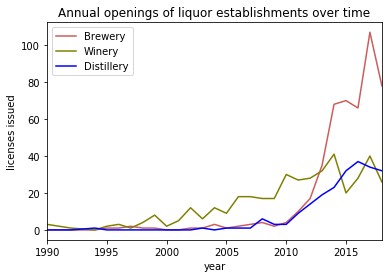

In [119]:
pl.subplot(1, 1, 1)
#subplots help decide the dimension and position of the plots within the larger plot (used when doing multiple plots)
ax = lfg['Brewery'].plot(kind="line",color='IndianRed',label='Brewery')
ax = lfg['Winery'].plot(kind="line",color='olive',label='Winery')
ax = lfg['Distillery'].plot(kind="line",color='blue',label='Distillery')

#ax = pl.plot(lfg['year'], lfg['Brewery'], kind='line')
#'o' is deciding what type of plot. so you can do 'o' 'ko-' 'r.-' 'r-'
pl.title('Annual openings of liquor establishments over time')
#ax.xaxis.set_ticklabels(['1990', '2000', '2010', '2018'], fontsize=15)
pl.ylabel('licenses issued')
pl.xlim(1990, 2018) 
pl.legend()

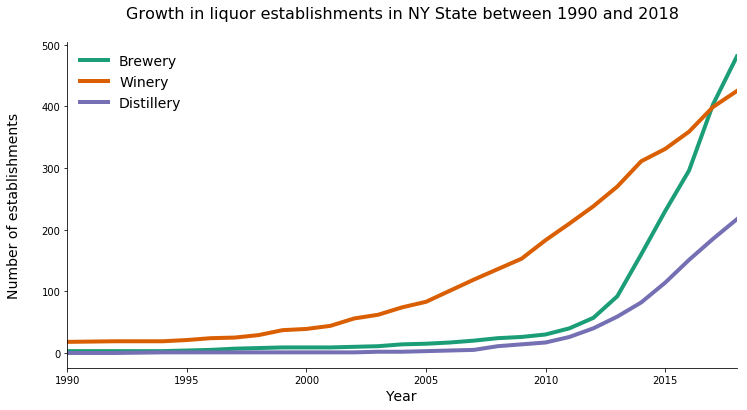

In [171]:
pl.figure(figsize=(12, 6))    
#subplots help decide the dimension and position of the plots within the larger plot (used when doing multiple plots)
ax = lfg['Brewery_cumsum'].plot(kind="line",color='#1b9e77',label='Brewery', linewidth=4)
ax = lfg['Winery_cumsum'].plot(kind="line",color='#d95f02',label='Winery', linewidth=4)
ax = lfg['Distillery_cumsum'].plot(kind="line",color='#7570b3',label='Distillery', linewidth=4)
#ax.xaxis.set_ticklabels('1990', '2000', '2010', fontsize=15)
#ax = pl.plot(lfg['year'], lfg['Brewery'], kind='line')
#'o' is deciding what type of plot. so you can do 'o' 'ko-' 'r.-' 'r-'
pl.title('Growth in liquor establishments in NY State between 1990 and 2018\n', fontsize=16)
pl.ylabel('Number of establishments\n', fontsize=14)
pl.xlabel('Year', fontsize=14)
pl.xlim(1990,2018)
pl.legend(frameon=False, fontsize=14, loc='best')
#ax.get_xaxis().tick_bottom()    
#ax.get_yaxis().tick_left()   
ax.spines["top"].set_visible(False)    
#ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
#ax.spines["left"].set_visible(False)
#pl.text(1987.5, -125 ,"Data source: ")
pl.savefig("growth-in-liquor-establishments.png")

#source: http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/